# Data Visualisation

## Objectives
* Answer business requirement 1:
    * The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew

## Inputs
* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/validation

## Outputs
* Image shape embeddings pickle file
* Mean and variability of images per label plot
* Plot to distinguish between mildew-infected and uninfected leaves
* Generate code that reloves business requirement 1 and can be used to build an image monatge on a streamlit dahsboard.

## Additional Comments
* No additional comments

# Set Data Directory

## Import Libraries

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Change Working Directory

* To change the working directory from its current folder to its parent folder
* To access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-in-cherry-leaves/jupyter_notebooks'

**To make the parent of the current directory the new current directory**
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


**To confirm the new current directory**

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-in-cherry-leaves'

## Set input directories
### Set train, validation, and test sets paths

In [5]:
# Set paths for train, validation, and test sets
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
validation_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directories

In [6]:
# Set output directories
version = 'v1'
file_path =f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Existing version already available create a new version')
    pass
else:
    os.makedirs(name=file_path)

### Set label names

In [7]:
# Set label names
labels = os.listdir(train_path)
print('Label for the images is', labels)

Label for the images is ['healthy', 'powdery_mildew']


# Data visualisation of image data

## Image shape
### Compute average image size on train set

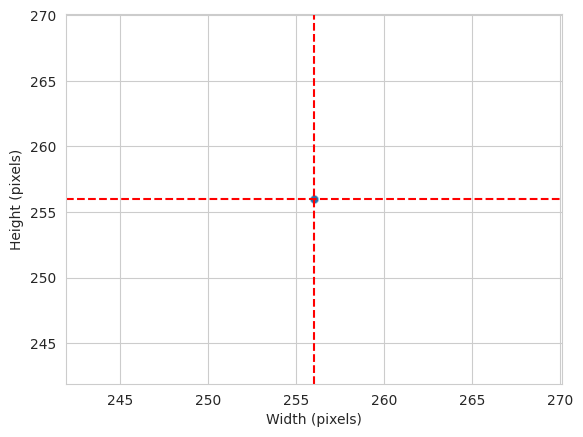

Width average: 256 
Height average: 256


In [8]:
# To compute average image size on train set
dim1, dim2 = [], []
for label in labels:
  for image_filename in os.listdir(train_path + '/'+ label):
    img = imread(train_path + '/' + label + '/'+ image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1) # image height
    dim2.append(d2) # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean,color='r', linestyle='--')
axes.axhline(y=dim2_mean,color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

**Conclusion:** The images in the train dataset are all the same size
* Save this along with the standard RGB in a pickle file 

In [9]:
# To check image shape
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

In [10]:
# To save image
joblib.dump(value=image_shape,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

## Average and variability of images per label
### Function to load images into an array using tensorflow

In [11]:
from tensorflow.keras.preprocessing import image

# To decalre a function to load images into an array using tensorflow
def load_image_as_array(my_data_dir, new_size=(50,50), num_imgs_per_label = 20):
    x, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)
    
    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            if counter < num_imgs_per_label:
                
                img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resize = image.img_to_array(img) / 255
                else:
                    img_resize = image.img_to_array(img)
                    
                x = np.append(x, img_resize).reshape(-1, new_size[0], new_size[1], img_resize.shape[2])
                y = np.append(y, label)
                counter += 1
    
    return x, y

### Load image shapes and labels in an array

In [12]:
# To load image shape and labels in an array
x, y = load_image_as_array(my_data_dir=train_path, new_size=image_shape, num_imgs_per_label=30)
print(x.shape, y.shape)

(60, 256, 256, 3) (60,)


### Plot and save mean and variability of the images per label 

In [13]:
# Declare function to plot mean and variability of the images per label using the definitions assigned above 
def plot_mean_var_per_label(x, y, figsize=(12,5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """
    
    # loop over all labels
    for display_label in np.unique(y):
        sns.set_style("white")

        # subset an array for a given label
        y = y.reshape(-1, 1, 1)
        bool_mask = np.any(y==display_label, axis=1).reshape(-1)
        arr = x[bool_mask] 
        
        # calculate the mean and standard deviation
        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label: {display_label} ====")
        print(f"Image Shape: {avg_img.shape}")
        
        # create a figure displaying the mean and variability of images
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average Image for {display_label}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variance image for {display_label}")
        axes[1].imshow(std_img, cmap='gray')
        
        # save the image
        if save_image:
            plt.savefig(f"{file_path}/avg_var_{display_label}.png", bbox_inches="tight", dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label: healthy ====
Image Shape: (256, 256, 3)
==== Label: powdery_mildew ====
Image Shape: (256, 256, 3)


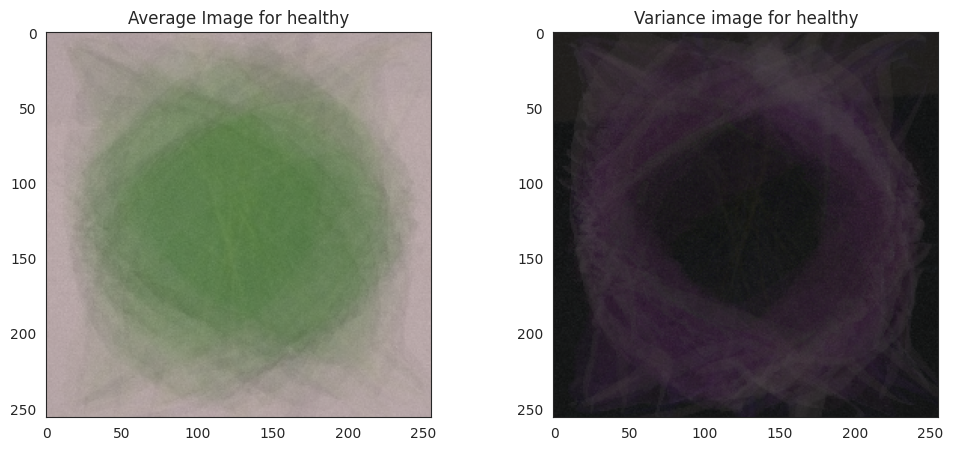

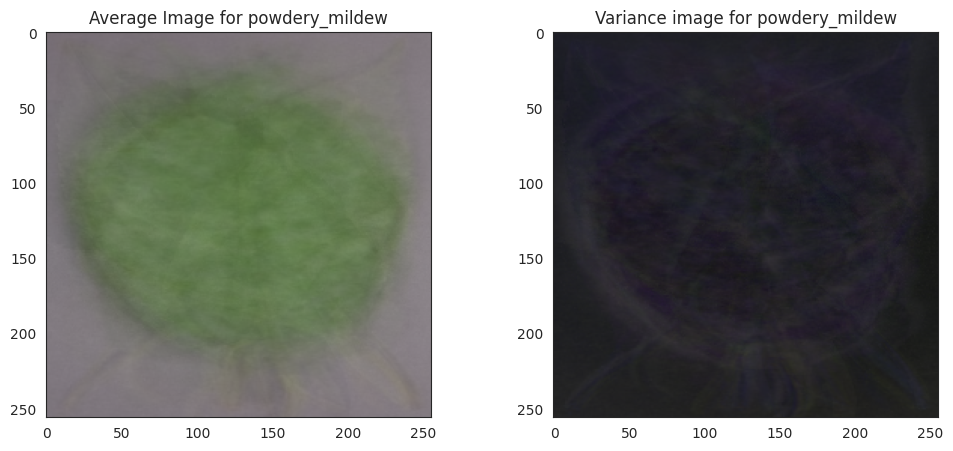

In [14]:
# Save the plot of mean and variability of the images per label
plot_mean_var_per_label(x=x, y=y, figsize=(12, 5), save_image=True)

## Difference between average mildew-contained and average uninfected leaf images

In [15]:
def subset_img_label(x, y, display_label):
    y = y.reshape(-1, 1, 1)
    bool_mask = np.any(y==display_label, axis=1).reshape(-1)
    df = x[bool_mask]
    return df
# Function for the difference between average mildew-contained and average uninfected leaf images
def diff_bet_avg_image_labels_data_as_array(x, y, label_1, label_2, figsize=(20,5), save_image=False):
    sns.set_style("white")
    
    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either {label_1} or {label_2} are not in {np.unique(y)}")
        return
        
    # Calculate mean from label1
    images_label = subset_img_label(x, y, label_1)
    label1_avg = np.mean(images_label, axis=0)
    
    # Calculate mean from label2
    images_label = subset_img_label(x, y, label_2)
    label2_avg = np.mean(images_label, axis=0)
    
    # Calculate and plot difference between average label1 and average label2
    diff_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average: {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average: {label_2}')
    axes[2].imshow(diff_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


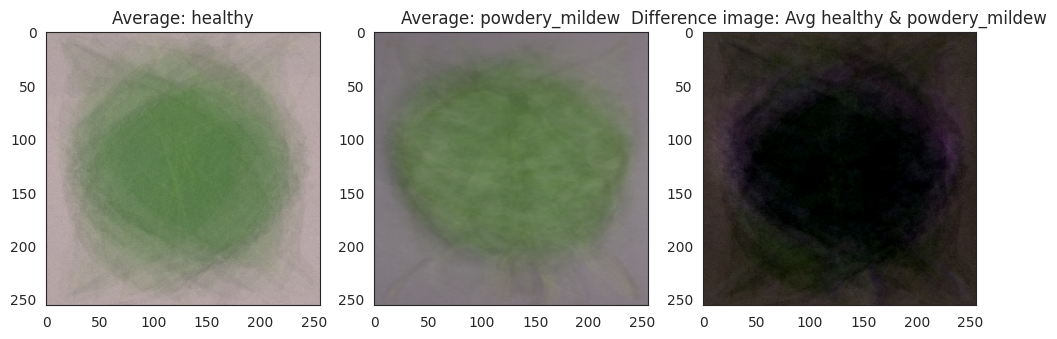

In [16]:
# Save the plot of difference between average mildew-contained and unifected leaf images
diff_bet_avg_image_labels_data_as_array(x=x, y=y, label_1='healthy', label_2='powdery_mildew',
                                       figsize=(12,10),
                                       save_image=True)

## Image Montage

In [17]:
import itertools
import random
sns.set_style("white")

# Function for image montage
def image_montage(dir_path, display_label, nrows, ncols, figsize=(15,10)):

    labels = os.listdir(dir_path)
    
    if display_label in labels:
        
        images_list = os.listdir(dir_path+'/'+display_label)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else: 
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return
        
        list_rows = range(0,nrows)
        list_cols = range(0,ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))
        
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for i in range(0, nrows*ncols):
            img = imread(dir_path + '/' + display_label +'/' + img_idx[i])
            img_shape = img.shape
            axes[plot_idx[i][0], plot_idx[i][1]].imshow(img)
            axes[plot_idx[i][0], plot_idx[i][1]].set_title(f"Witdth {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[i][0], plot_idx[i][1]].set_xticks([])
            axes[plot_idx[i][0], plot_idx[i][1]].set_yticks([])
        plt.tight_layout()
        plt.show()
    else:
        print("The selected label does not exists")
        print(f"The existing options are: {labels}")

In [ ]:
# Image montage in all labels
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  display_label=label,
                  nrows=3, ncols=3,
                  figsize=(10,15)
                  )
    print("\n")

## Conclusions and Next Steps
## Conclusions
* The images in the train data set are all the same size and saved as pickle file
* The business requirement 1 was achieved with: 
    * the average images and variability images for each class (healthy or powdery mildew)
    * the differences between average healthy and average powdery mildew cherry leaves
    * an image montage for each class

## Next Steps
* Answer business requirement 2:
    * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

# Push files to Repo
## Push generated/new files from this session to GitHub repository

### Git status

In [ ]:
! git status


### Git add

In [ ]:
! git add .

### Git commit

In [ ]:
! git commit -am "Add data visualization"

### Git push

In [ ]:
! git push